In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from xml.dom import minidom
import re
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en import English
import spacy
from spacy.lang.en.examples import sentences 
import en_core_web_md

2022-05-25 02:43:13.153768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-25 02:43:13.153808: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
# utworzenie ramki danych
all_files = os.listdir('../ecgen-radiology')

d = {
    'COMPARISON' : [],
    'INDICATION' : [],
    'FINDINGS'   : [],
    'IMPRESSION' : [],
    'CAPTION'    : [],
    'DISEASES'   : []
}

for f in all_files:
    file = minidom.parse('../ecgen-radiology/' + f)
    
    caption = file.getElementsByTagName('caption')
    
    try:
        d['CAPTION'].append(caption[0].childNodes[0].data)
    except IndexError:
        d['CAPTION'].append(None)
    
    models = file.getElementsByTagName('AbstractText')
    
    for i in range(len(models)):
        key = str(models[i].attributes['Label'].value)
        try:
            val = str(models[i].childNodes[0].data)
        except IndexError:
            val = ''
            
        d[key].append(val)
        
        
    dis = file.getElementsByTagName('major')
    dis2 = file.getElementsByTagName('automatic')

    text = ''
    for i in range(len(dis)):
        try:
            text = text + dis[i].childNodes[0].data + ', '
        except IndexError:
            continue

    for i in range(len(dis2)):
        try:
            text = text + dis2[i].childNodes[0].data + ', '
        except IndexError:
            continue

    d['DISEASES'].append(text)
        
for k in d.keys():
    d[k] = np.array(d[k])
    
df = pd.DataFrame(d)
df['DISEASES'] = df['DISEASES'].str[:-2]
df['ILL'] = np.where(df['DISEASES'] == 'normal', 0, 1)

In [5]:
df.head(5)

,COMPARISON,INDICATION,FINDINGS,IMPRESSION,CAPTION,DISEASES,ILL
0,"XXXX, XXXX.",Post pacemaker placement.,"Dual-XXXX cardiac pacemaker is in stable, XXXX...","Dual-XXXX cardiac pacemaker in stable, XXXX po...",None,"Implanted Medical Device, Epicardial Fat/promi...",1
1,"XXXX, XXXX","Dyspnea, leg XXXX, cellulitis.",,Moderate enlargement of the heart XXXX. This s...,"2 VIEW CHEST: XXXX, XXXX at XXXX hours.","Cardiac Shadow/enlarged/moderate, Infiltrate/l...",1
2,None,"XXXX-year-old female, XXXX, XXXX, chest pain.",Right lower lobe patchy opacities noted. Heart...,"Patchy right lower lobe opacities, XXXX infect...",PA and lateral views of the chest dated XXXX.,"Opacity/lung/lower lobe/right/patchy, Thoracic...",1
3,None,"Syncope with collapse, XXXX, pain",Heart size and mediastinal contour are normal....,Findings suggestive of emphysema. No acute car...,Xray Chest PA and Lateral,"Lung/hyperdistention, Thoracic Vertebrae/degen...",1
4,None.,"XXXX chest pain, XXXX, history of acid reflux.",The cardiomediastinal silhouette and pulmonary...,1. Clear lungs. 2. Mildly blunted right costop...,"PA and lateral views of the chest dated XXXX, ...",Costophrenic Angle/right/blunted/mild,1


In [6]:
def clean(data):
    for c in data.columns:
        data[c] = data[c].apply(lambda x : x.lower())
        data[c] = data[c].apply(lambda x : re.sub(r'[^A-Za-z ]+', ' ', x))
        data[c] = data[c].apply(lambda x : re.sub(r'[A-Za-z]*xxxx[A-Za-z]*', '', x))
    
    return data

df = df.fillna('')

df2 = df[['FINDINGS', 'ILL']]
df2['FINDINGS'] = clean(df2[['FINDINGS']])
df2.head()

/tmp/ipykernel_43297/3718820318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[c] = data[c].apply(lambda x : x.lower())
/tmp/ipykernel_43297/3718820318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[c] = data[c].apply(lambda x : re.sub(r'[^A-Za-z ]+', ' ', x))
/tmp/ipykernel_43297/3718820318.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,FINDINGS,ILL
0,dual cardiac pacemaker is in stable positio...,1
1,,1
2,right lower lobe patchy opacities noted heart...,1
3,heart size and mediastinal contour are normal ...,1
4,the cardiomediastinal silhouette and pulmonary...,1


In [7]:
df2['ILL'].value_counts()

1    2564
0    1391
Name: ILL, dtype: int64

Będziemy wykonywać klasyfikację binarną na podstawie kolumny ILL stwierdzającej, czy pacjent jest chory czy zdrowy. Uczymy za pomocą kolumn FINDINGS lub IMPRESSION. Widać dysproporcję między klasami.

Na podstawie:
https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/47_BERT_text_classification/BERT_email_classification-handle-imbalance.ipynb

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df2['FINDINGS'],df2['ILL'],
                                                    stratify=df2['ILL'])


In [9]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


2022-05-25 02:43:30.289094: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-25 02:43:30.289130: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-25 02:43:30.289157: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (przemek-Latitude-E7450): /proc/driver/nvidia/version does not exist
2022-05-25 02:43:30.289375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-25 02:45:06.814699: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9376

In [10]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)



<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.51327264, -0.88845724, ..., -0.74748874,
        -0.75314736,  0.91964483],
       [-0.8720836 , -0.5054398 , -0.9444668 , ..., -0.85847515,
        -0.7174535 ,  0.88082975]], dtype=float32)>

In [11]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [13]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [15]:
model.fit(X_train, y_train, epochs=2)

Epoch 1/2
93/93 [==============================] - 944s 10s/step - loss: 0.5979 - accuracy: 0.6811 - precision: 0.6955 - recall: 0.9038
Epoch 2/2
93/93 [==============================] - 923s 10s/step - loss: 0.5772 - accuracy: 0.7033 - precision: 0.7270 - recall: 0.8684


In [16]:
model.evaluate(X_test, y_test)

31/31 [==============================] - 284s 9s/step - loss: 0.5683 - accuracy: 0.7219 - precision: 0.7052 - recall: 0.9813


[0.5682763457298279, 0.721941351890564, 0.7051569223403931, 0.9812792539596558]

In [17]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

31/31 [==============================] - 284s 9s/step


In [18]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[ 85, 263],
       [ 12, 629]])

Text(33.0, 0.5, 'Truth')

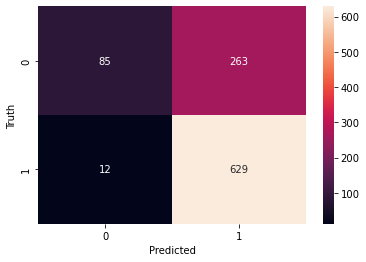

In [20]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')